# Paddlepaddle实现逻辑回归 - 识别猫

欢迎大家来到这个有趣的实验！在这个实验中，大家将学使用PaddlePaddle实现Logistic回归模型来解决识别猫的问题，一步步跟随内容完成训练，加深对逻辑回归理论内容的理解并串联各个知识点，收获对神经网络和深度学习概念的整体把握。 

** 你将学会 **

- 预处理图片数据

- 利用PaddlePaddle框架实现Logistic回归模型：

在开始实验之前，让我们简单介绍一下图片处理的相关知识：

** 图片处理 **

由于识别猫问题涉及到图片处理指示，这里对计算机如何保存图片做一个简单的介绍。在计算机中，图片被存储为三个独立的矩阵，分别对应图3-6中的红、绿、蓝三个颜色通道，如果图片是64\*64像素的，就会有三个64\*64大小的矩阵，要把这些像素值放进一个特征向量中，需要定义一个特征向量X，将三个颜色通道中的所有像素值都列出来。如果图片是64\*64大小的，那么特征向量X的总纬度就是64\*64\*3，也就是12288维。这样一个12288维矩阵就是Logistic回归模型的一个训练数据。

<img src="images/image_to_vector.png" style="width:550px;height:300px;">

现在，让我们正式进入实验吧！

## 1 - 引用库

首先，载入几个需要用到的库，它们分别是：

- numpy：一个python的基本库，用于科学计算
- matplotlib.pyplot：用于生成图，在验证模型准确率和展示成本变化趋势时会使用到
- lr_utils：定义了load_datase()方法用于载入数据
- paddle.fluid：PaddlePaddle深度学习框架

In [1]:
import sys
import numpy as np

import lr_utils
import matplotlib.pyplot as plt

import paddle
import paddle.fluid as fluid

%matplotlib inline

## 2 - 数据预处理

这里简单介绍数据集及其结构。数据集以hdf5文件的形式存储，包含了如下内容：

- 训练数据集：包含了m_train个图片的数据集，数据的标签（Label）分为cat（y=1）和non-cat（y=0）两类。
- 测试数据集：包含了m_test个图片的数据集，数据的标签（Label）同上。

单个图片数据的存储形式为（num_x, num_x, 3），其中num_x表示图片的长或宽（数据集图片的长和宽相同），数字3表示图片的三通道（RGB）。
在代码中使用一行代码来读取数据，读者暂不需要了解数据的读取过程，只需调用load_dataset()方法，并存储五个返回值，以便后续的使用。
    
需要注意的是，添加“_orig”后缀表示该数据为原始数据，因为之后还需要对数据进行进一步处理。未添加“_orig”的数据则表示之后不对该数据作进一步处理。

In [2]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = lr_utils.load_dataset()

y = [0], it's a 'non-cat' picture.


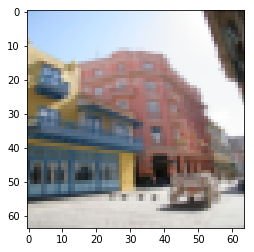

In [3]:
# 图片示例
index = 23
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

获取数据后的下一步工作是获得数据的相关信息，如训练样本个数 m_train、测试样本个数 m_test 和图片的长度或宽度 num_x，使用 numpy.array.shape 来获取数据的相关信息。


** 练习: ** 查看样本信息:
    - m_train (训练样本数)
    - m_test (测试样本数)
    - num_px （图片长或宽）
`train_set_x_orig` 是一个(m_train, num_px, num_px, 3)形状的 numpy 数组。举个例子，你可以使用 `train_set_x_orig.shape[0]` 来获得 `m_train`。

In [4]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = test_set_x_orig.shape[1]
### END CODE HERE ###

print ("训练样本数: m_train = " + str(m_train))
print ("测试样本数: m_test = " + str(m_test))
print ("图片高度/宽度: num_px = " + str(num_px))
print ("图片大小: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

训练样本数: m_train = 209
测试样本数: m_test = 50
图片高度/宽度: num_px = 64
图片大小: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**期望输出：**: 
<table style="width:15%">
  <tr>
    <td>**m_train**</td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>**m_test**</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>**num_px**</td>
    <td> 64 </td> 
  </tr>
  
</table>



接下来需要对数据作进一步处理，为了便于训练，你可以忽略图片的结构信息，将包含图像长、宽和通道数信息的三维数组压缩成一维数组，图片数据的形状将由(64, 64, 3)转化为(64 * 64 * 3, 1)。

** 练习：** 

将数据形状由(64, 64, 3)转化为(64 * 64 * 3, 1)。

** 技巧：**

我们可以使用一个小技巧来将(a,b,c,d)形状的矩阵转化为 (b$*$c$*$d, a)形状的矩阵: 

```python
X_flatten = X.reshape(X.shape[0], -1)
```


In [5]:
# 定义维度
DATA_DIM = num_px * num_px * 3

# 转换数据形状

### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten = train_set_x_orig.reshape(m_train,-1)
test_set_x_flatten = test_set_x_orig.reshape(m_test,-1)
### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (209, 12288)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (50, 12288)
test_set_y shape: (1, 50)


**期望输出**: 

<table style="width:35%">
  <tr>
    <td>**train_set_x_flatten shape**</td>
    <td> (209, 12288)</td> 
  </tr>
  <tr>
    <td>**train_set_y shape**</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>**test_set_x_flatten shape**</td>
    <td>(50, 12288)</td> 
  </tr>
  <tr>
    <td>**test_set_y shape**</td>
    <td>(1, 50)</td> 
  </tr>
</table>

在开始训练之前，还需要对数据进行归一化处理。图片采用红、绿、蓝三通道的方式来表示颜色，每个通道的单个像素点都存储着一个0-255的像素值，所以图片的归一化处理十分简单，只需要将数据集中的每个值除以255即可，但需要注意的是结果值应为 float 类型，直接除以 255 会导致结果错误，在 Python 中除以255.即可将结果转化为float类型。
现在让我们来归一化数据吧！


In [6]:
### START CODE HERE ### (≈ 2 lines of code)
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.
### END CODE HERE ###

为了方便后续的测试工作，添加了合并数据集和标签集的操作，使用 numpy.hstack 实现 numpy 数组的横向合并。
 

In [7]:
train_set = np.hstack((train_set_x, train_set_y.T))
test_set = np.hstack((test_set_x, test_set_y.T))

<font color='blue'>
**经过上面的实验，大家应该记住:**

对数据进行预处理的一般步骤是:
    
- 了解数据的维度和形状等信息，例如(m_train, m_test, num_px, ...)
- 降低数据纬度，例如将数据维度(num_px, num_px, 3)转化为(num_px \* num_px \* 3, 1)
- 数据归一化

至此我们就完成了数据预处理工作！在接下来的练习中我们将构造reader，用于读取数据。

## 3 - 构造reader

构造read_data()函数，来读取训练数据集train_set或者测试数据集test_set。它的具体实现是在read_data()函数内部构造一个reader()，使用yield关键字来让reader()成为一个Generator（生成器），注意，yield关键字的作用和使用方法类似return关键字，不同之处在于yield关键字可以构造生成器（Generator）。虽然我们可以直接创建一个包含所有数据的列表，但是由于内存限制，我们不可能创建一个无限大的或者巨大的列表，并且很多时候在创建了一个百万数量级别的列表之后，我们却只需要用到开头的几个或几十个数据，这样造成了极大的浪费，而生成器的工作方式是在每次循环时计算下一个值，不断推算出后续的元素，不会创建完整的数据集列表，从而节约了内存使用。

** 练习：**现在让我们使用yield来构造一个reader()吧！

In [8]:
# 读取训练数据或测试数据
def read_data(data_set):
    """
        一个reader
        Args:
            data_set -- 要获取的数据集
        Return:
            reader -- 用于获取训练数据集及其标签的生成器generator
    """
    def reader():
        """
        一个reader
        Args:
        Return:
            data[:-1], data[-1:] -- 使用yield返回生成器(generator)，
                    data[:-1]表示前n-1个元素，也就是训练数据，data[-1:]表示最后一个元素，也就是对应的标签
        """
        for data in data_set:
            ### START CODE HERE ### (≈ 1 lines of code)
            yield data[:-1], data[-1:]
            ### END CODE HERE ###
    return reader




In [9]:
test_array = [[1,1,1,1,0],
                [2,2,2,2,1],
                [3,3,3,3,0]]

print("test_array for read_data:")
for value in read_data(test_array)():
    print(value)

test_array for read_data:
([1, 1, 1, 1], [0])
([2, 2, 2, 2], [1])
([3, 3, 3, 3], [0])


**期望输出**: 

<table>
  <tr>
    <td>([1, 1, 1, 1], [0])</td>
  </tr>
  <tr>
    <td>([2, 2, 2, 2], [1])</td> 
  </tr>
    <td>([3, 3, 3, 3], [0])</td> 
  </tr>
</table>

## 4 - 训练过程

完成了数据的预处理工作并构造了read_data()来读取数据，接下来将进入模型的训练过程，使用 PaddlePaddle 来定义构造可训练的 Logistic 回归模型，关键步骤如下：

- 初始化

- 配置网络结构和设置参数
    - 配置网络结构
    - 定义损失函数 cost
    - 定义优化器 optimizer

- 模型训练

- 模型检验

- 预测


** （1）定义训练场所 **

首先进行最基本的初始化操作，在 PaddlePaddle 中使用 place = fluid.CUDAPlace(#) 来进行初始化：

- use_cuda = False 表示不使用gpu进行训练

In [10]:
# 使用CPU训练
use_cuda = False
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

** （2）配置网络结构和设置参数 **

** 配置网络结构 **

我们知道 Logistic 回归模型结构相当于一个只含一个神经元的神经网络，如下图所示，只包含输入数据以及输出层，不存在隐藏层，所以只需配置输入层(input)、输出层(predict)和标签层(label)即可。

<img src="images/logistic.png" width="200px">

** 练习：**接下来让我们使用 PaddlePaddle 提供的接口开始配置 Logistic 回归模型的简单网络结构吧，一共需要配置三层：

** 输入层： **

我们可以定义 x = fluid.layers.data(name='x', shape=[DATA_DIM], dtype='float32') 来表示生成一个数据输入层，名称为“x”，数据类型为 data_dim 维向量；

在定义输入层之前，我们需要使用之前计算的 num_px 来获取数据维度 data_dim，data_dim=num_px \* num_px \* 3

** 输出层： **

我们可以定义 y_predict = fluid.layers.fc(input=x, size=1, act='sigmoid') 表示生成一个全连接层，输入数据为x，神经元个数为1，激活函数为Sigmoid()；

** 标签层 **

我们可以定义 y = fluid.layers.data(name='y', shape=[1], dtype='float32') 表示生成一个数据层，名称为“y”，数据类型为1维向量。


In [11]:
# 输入层，fluid.layers.data表示数据层,name=’x’：名称为x,输出类型为tensor
# shape=[DATA_DIM]:数据为DATA_DIM维向量
# dtype='float32'：数据类型为float32

### START CODE HERE ### (≈ 1 lines of code)
x = fluid.layers.data(name='x', shape=[DATA_DIM], dtype='float32')
### END CODE HERE ###

# 标签数据，fluid.layers.data表示数据层,name=’y’：名称为y,输出类型为tensor
# shape=[1]:数据为1维向量

### START CODE HERE ### (≈ 1 lines of code)
y = fluid.layers.data(name='y', shape=[1], dtype='float32')
### START CODE HERE ### (≈ 1 lines of code)

# 输出层，fluid.layers.fc表示全连接层，input=x: 该层输入数据为x
# size=1：神经元个数，act=sigmoid：激活函数为sigmoid函数

### START CODE HERE ### (≈ 1 lines of code)
y_predict = fluid.layers.fc(input=x, size=1, act='sigmoid')
### END CODE HERE ###


** 定义损失函数 **

在配置网络结构之后，我们需要定义一个损失函数来计算梯度并优化参数，在这里我们可以使用 PaddlePaddle 提供的均方误差损失函数，定义 loss = fluid.layers.square_error_cost(input=y_predict, label=y)，avg_loss = fluid.layers.mean(cost) 使用 y_predict 与 y(label) 计算成本。

In [12]:
# 定义成本函数为均方差损失函数

### START CODE HERE ### (≈ 2 lines of code)
loss = fluid.layers.square_error_cost(input=y_predict, label=y)
avg_loss = fluid.layers.mean(loss)
### END CODE HERE ###

**封装训练参数**

将设计完成的网络参数写入 sigmoid_regression()函数和train_program() 函数，便于训练时调用


In [13]:
def sigmoid_regression():
    x = fluid.layers.data(name='x', shape=[DATA_DIM], dtype='float32')
    y_predict = fluid.layers.fc(input=x, size=1, act='sigmoid')
    return y_predict

In [14]:
def train_program():
    #输入层与标签层作为输入传进函数，这里只需定义输出层与损失函数
    
    ### START CODE HERE ###(≈ 3 lines of code)
    y_predict = sigmoid_regression()
    y = fluid.layers.data(name='y', shape=[1], dtype='float32')
    cost = fluid.layers.square_error_cost(input=y_predict, label=y)
    avg_cost = fluid.layers.mean(cost)
    ### END CODE HERE ###

    return [avg_cost,y_predict]

** 优化方法 **

损失函数定义确定后，需要定义参数优化方法。为了改善模型的训练速度以及效果，学术界先后提出了很多优化算法，包括： Momentum、RMSProp、Adam 等，已经被封装在fluid内部，读者可直接调用。本次可以用 sgd_optimizer = fluid.optimizer.Adam(learning_rate= ) 使用 Adam 的方法优化，其中 learning_rate 可自己尝试修改。

In [15]:
def optimizer_program():
    return fluid.optimizer.Adam(learning_rate=0.0001)

** 其它配置 **

feed_order=['x', 'y'] 是数据层名称和数组索引的映射，用于定义数据的读取顺序。  
avg_costs=[] 用于记录损失函数的变化过程。

In [16]:
avg_costs=[]
feed_order=['x','y']

** 获取训练数据 **

关于参数的解释如下：

- paddle.reader.shuffle(read_data(train_set), buf_size=5000)表示trainer从read_data(train_set)这个reader中读取了buf_size=5000大小的数据并打乱顺序
- paddle.batch(reader(), batch_size=BATCH_SIZE)表示从打乱的数据中再取出BATCH_SIZE=32大小的数据进行一次迭代训练

In [17]:
BATCH_SIZE=32

# 设置训练reader
train_reader = paddle.batch(
    paddle.reader.shuffle(
        read_data(train_set), buf_size=5000),
    batch_size=BATCH_SIZE)

#设置测试 reader
test_reader = paddle.batch(
    paddle.reader.shuffle(
        read_data(test_set), buf_size=5000),
    batch_size=BATCH_SIZE)

** 创建训练器 **

训练器创建训练器时需要提供3个主要信息：
1. 一个配置好的网络拓扑结构
2. 训练的硬件场所
3. 具体的优化方法

In [18]:
trainer = fluid.Trainer(
    train_func= train_program,
    place= place,
    optimizer_func= optimizer_program)

In [19]:
print(fluid.default_main_program().to_string(True))

blocks {
  idx: 0
  parent_idx: -1
  vars {
    name: "square_error_cost_0.tmp_1"
    type {
      type: LOD_TENSOR
      lod_tensor {
        tensor {
          data_type: FP32
          dims: -1
          dims: 1
        }
        lod_level: 0
      }
    }
    persistable: false
  }
  vars {
    name: "square_error_cost_0.tmp_0"
    type {
      type: LOD_TENSOR
      lod_tensor {
        tensor {
          data_type: FP32
          dims: -1
          dims: 1
        }
        lod_level: 0
      }
    }
    persistable: false
  }
  vars {
    name: "fc_0.tmp_1"
    type {
      type: LOD_TENSOR
      lod_tensor {
        tensor {
          data_type: FP32
          dims: -1
          dims: 1
        }
        lod_level: 0
      }
    }
    persistable: false
  }
  vars {
    name: "fc_0.b_0"
    type {
      type: LOD_TENSOR
      lod_tensor {
        tensor {
          data_type: FP32
          dims: 1
        }
      }
    }
    persistable: true
  }
  vars {
    name: "fc_0.tmp_0

** （3）训练模型 **

上述内容进行了模型初始化、网络结构的配置并创建了训练函数、硬件位置、优化方法，接下来利用上述配置进行模型训练。


利用 train（） 即可开始真正的模型训练，我们可以设置参数如下：




- a. 成本函数（avg_cost）

首先，我们调用定义好的train_program()用于计算avg_cost。

- b. 优化器（optimizer）

在获取avg_cost之后，我们获取优化器oprimizer。通过minimize(avg_cost)来将最小化avg_cost作为梯度更新标准。


- c. 定义执行器(exe)

根据是否使用gpu来定义运算场所为fluid.CUPAPlace或者fluid.CPUPlace()，在本实验中use_cuda默认为False，所以选择fluid.CPUPlace()作为运算场所。

通过fluid.Executor(place)来设置执行器。

- d. 提供数据(feeder)

定义feeder来为接下来的训练提供数据，通过fluid.DataFeeder(place=place, feed_list=[x, y])来设置feeder的目标训练场所(place)以及提供的数据列表(feed_list)。

- e. 执行训练(exe.run)

经过以上步骤的设置，我们定义了网络结构、成本函数、优化器、数据、运算场所和执行器，接下来即可开始模型的训练过程。我们设置PASS_NUM=2000让训练程序循环完成2000次迭代训练，在训练过程中间隔输出Average cost，通过fluid.io.save_inference_model()保存模型，用于之后的预测过程(inference)。


In [25]:
# 使用paddle.v2.plot 绘制训练过程中损失函数的变化情况
from paddle.v2.plot import Ploter
train_title = "Train cost"
test_title = "Test cost"
cost_ploter = Ploter(train_title,test_title)

def train(save_dirname, use_cuda=False, is_local=True):
    
    # 读取损失函数
    avg_cost, y_predict = train_program()
    
    # 定义优化器
    optimizer = optimizer_program()
    optimizer.minimize(avg_cost)
    
    
    # 提供数据
    feeder = fluid.DataFeeder(place=place, feed_list=[x, y])
    
    # 设置执行器
    exe = fluid.Executor(place)
    exe.run(fluid.default_startup_program())
    
    # 开始训练
    PASS_NUM = 2000
    
    for pass_id in range(PASS_NUM):
        for batch_id, data in enumerate(train_reader()):
            avg_cost_value = exe.run(fluid.default_main_program(),
                                    feed=feeder.feed(data),
                                    fetch_list=[avg_cost])
                
            
            
            if pass_id % 100 == 0 and batch_id == 0:
                avg_costs.append(avg_cost_value[0])
                
                # 以图像形式打印训练集损失函数
                cost_ploter.append(train_title, pass_id, avg_cost_value[0])
                cost_ploter.plot()
            
                
                
                if save_dirname is not None:    
                    fluid.io.save_inference_model(save_dirname, ['x'], [y_predict], exe)


** 开始训练 **

我们现在可以通过调用train()来开始训练了，通过观察损失函数图像看看自己的模型是不是完美了呢！

尝试调整 train()中的PASS_NUM 观察损失函数的变化吧（可以先尝试2000）



定义模型保存路径 save_dirname，通过 train(save_dirname) 来进行模型训练。

通过输出结果可以看出，cost 逐渐减小到了一个可接受的范围内，由于本次 cost 值域很小，因此看起来仍存在波动，但此时的模型已经可以作为不错的分类模型了。

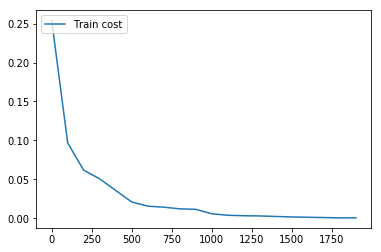

<Figure size 432x288 with 0 Axes>

In [26]:

save_dirname="recognize_cat_inference.model"
train(save_dirname)


# 5-预测

首先我们定义calc_accuracy()函数，将结果转化为二分类结果并计算预测正确的结果数量，用以获取训练模型的预测准确度。

**注意**: 这里使用一个prediction数组参数用于存储预测结果，方便后续查看。

In [22]:
prediction = []
def calc_accuracy(result, label):
    count = 0
    for i in range(len(result)):
        if result[i] < 0:
            prediction.append(0)
            if label[i] == 0:
                count += 1
        elif result[i] >= 0:
            prediction.append(1)
            if label[i] == 1:
                count += 1
    return count / float(len(label))


接下来进行模型的预测过程：

#### a. 定义运算场所(place)和执行器(exe)

首先，定义预测过程的计算场所和执行器

#### b. scope

定义一个新的scope(关于scope的详细描述请参考[Design of Scope In PaddlePaddle](http://www.paddlepaddle.org/docs/0.14.0/documentation/fluid/zh/design/concepts/scope.html?highlight=scope))，并使用fluid.scope_guard()切换到新的scope中。

#### c. 载入模型

使用fluid.io.load_inference_model()来载入我们先前保存的模型。在载入模型时可获取三个变量：

- inference_program: 预测程序(inference program desc)

- feed_target_names: 在预测时提供的数据名，在本例中为x, y

- fetch_targets: 希望获取的预测结果

#### d. 获取数据

定义test_reader获取测试数据

#### e. 执行预测

通过exe.run()来执行预测并获取结果，传入在c.载入模型步骤中获取的预测程序inference_program，设置提供数据feed为x，并设置fetch_list来获取测试结果。

#### f. 计算准确率

通过刚刚定义的calc_accuracy()函数来计算并返回预测准确率、保存预测结果。

**注意**: 大家可以通过修改test_reader中的TEST_SET为TRAINING_SET来获取训练数据集上的预测准确率，了解模型对训练数据集的拟合程度。

#### g. 模型检验

获取测试数据图片样例并与预测结果进行对比，检验模型效果。

In [23]:
def infer(use_cuda=False, save_dirname=None):
    if save_dirname is None:
        return
    place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
    exe = fluid.Executor(place)
    inference_scope = fluid.core.Scope()
    with fluid.scope_guard(inference_scope):
        [inference_program, feed_target_names,
        fetch_targets] = fluid.io.load_inference_model(save_dirname, exe)
        
        test_reader = paddle.batch(
            read_data(test_set), batch_size=50
        )

        test_data = test_reader().next()
        test_x = np.array([data[0] for data in test_data]).astype('float32')
        test_label = np.array([data[1] for data in test_data]).astype('float32')

        assert feed_target_names[0] == 'x'
        results = exe.run(inference_program,
                        feed={feed_target_names[0]: np.array(test_x)},
                        fetch_list=fetch_targets)
        print("accuracy: {}".format(calc_accuracy(results[0], test_label)))
        index = 14
        plt.imshow((np.array(test_x[index])).reshape((64, 64, 3)))
        print ("y = " + str(test_label[index]) + ", you predicted that it is a \""
               + classes[prediction[index]].decode("utf-8") +  "\" picture.")

accuracy: 0.72
y = [0.], you predicted that it is a "non-cat" picture.


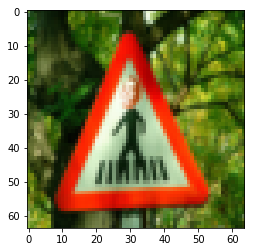

In [24]:

infer(False, save_dirname)

# 6 - 总结

通过这个练习我们应该记住：

1. 单层神经网络基础是逻辑回归，配置网络时需要耐心，防止出错！

2. fluid训练模型的基本步骤: 

    - 配置网络结构：
    
    - 定义成本函数avg_cost
    
    - 定义优化器optimizer
    
    - 获取训练数据
    
    - 定义运算场所(place)和执行器(exe)
    
    - 提供数据(feeder)

    - 执行训练(exe.run)
    
3. fluid模型预测的基本步骤:

    - 定义运算场所(place)和执行器(exe)

    - 切换inference_scope
    
    - 载入模型

    - 获取测试数据
    
    - 执行预测

    - 计算准确率

    - 模型检验

3. 练习中参数的初始化策略和学习率调整会对结果产生较大影响，可以尝试改变二者观察结果。



至此Logistic回归模型的训练工作完成，我们发现在使用PaddlePaddle进行模型配置和训练的过程中不用考虑参数的初始化、成本函数、激活函数、梯度下降、参数更新和预测等具体细节，只需要简单地配置网络结构和trainer即可，并且PaddlePaddle提供了许多接口来改变学习率、成本函数、批次大小等许多参数来改变模型的学习效果，使用起来更加灵活，方便测试，在之后的练习中，我们会对PaddlePaddle更加熟悉。
